# Forecast a multivariate time series : Stock Market Price 

## 1. Data Loading and Setting

**1-1. 신한 TR에서 불러올 정보 셋팅**

In [1]:
code = '005930'          
tr_name = 'TR_SCHART'
term = '1'
start_date = '20200101'   
end_date = '20200311'
Lookup = '9999' 

**1-2. TR json 파일을 데이터프레임으로 변환**

In [2]:
url = 'http://ssecd.roboadvisor.co.kr:9999/' + tr_name + '?0=' + code + '&1=' + term + '&2=10' +\
      '&3=' + start_date + '&4=' + end_date + '&5=' + Lookup

In [3]:
from urllib.request import urlopen
url_page = urlopen(url)

In [4]:
import json
url_data = json.loads(url_page.read())

In [5]:
import pandas as pd
data = pd.DataFrame(url_data)

**1-3. 데이터프레임의 칼럼명과 데이터 순서 등을 지정**

In [6]:
data.columns = ['date','time','open','high','low','close','price_ccr','volume_ccr','rock','volume','volume_price']
data = data[['date', 'time', 'open', 'high', 'low', 'close', 'volume', 'volume_price']]
data = data[::-1]
data['date_time'] = data['date'] + data['time']
data = data.set_index('date_time')
data = data[['open', 'high', 'low', 'close', 'volume', 'volume_price']]

**1-4. 데이터 속성을 모두 정수로 변경**

In [7]:
for column in data.columns : 
    data[column] = data[column].apply(lambda x : int(x))

**1-5. 데이터 결과**

In [8]:
data

,open,high,low,close,volume,volume_price
date_time,,,,,,
202001021010,55500,56000,55500,55500,1847051,102799934000
202001021020,55500,55700,55300,55300,671417,37250860500
202001021030,55400,55400,55100,55300,488563,26984027000
202001021040,55300,55300,55100,55300,289139,15959755900
202001021050,55200,55300,55100,55200,417215,23020438200
...,...,...,...,...,...,...
202003111450,52100,52200,52000,52100,1195119,62271900000
202003111500,52100,52400,52000,52300,860750,44942249300
202003111510,52300,52400,52100,52100,1116420,58373679200


In [9]:
data.describe()

,open,high,low,close,volume,volume_price
count,1869.000000,1869.000000,1869.000000,1869.000000,1.869000e+03,1.869000e+03
mean,58375.441413,58480.042804,58248.314607,58378.651685,4.757080e+05,2.747821e+10
std,2384.425146,2379.130084,2399.840197,2387.132956,5.191502e+05,2.953392e+10
min,52100.000000,52200.000000,52000.000000,52100.000000,0.000000e+00,0.000000e+00
25%,56500.000000,56600.000000,56300.000000,56500.000000,1.984670e+05,1.178510e+10
50%,58900.000000,59000.000000,58800.000000,58900.000000,3.571690e+05,2.080670e+10
75%,60100.000000,60200.000000,60000.000000,60100.000000,5.672050e+05,3.257072e+10
max,62700.000000,62800.000000,62600.000000,62800.000000,7.771531e+06,4.554117e+11


## 2. Data Visualization

**2.1 경고창 무시**

In [10]:
import warnings
warnings.filterwarnings(action='ignore') 

**2.2 각 피쳐별 시계열 그래프**

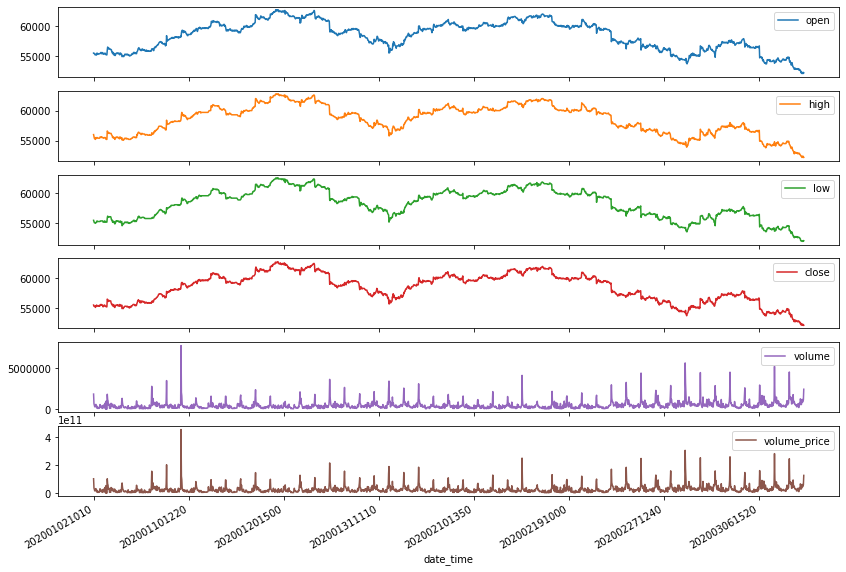

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,10)
data.plot(subplots=True)
plt.show()

## 3. Data Handling

**3.1 학습과 테스트 데이터를 나누는 지점 --> 90 : 10**

In [12]:
TRAIN_SPLIT = int(0.9 * len(data))

**3.2 피쳐 정규화 진행 (학습 데이터의 평균과 표준편차를 테스트 데이터에도 지정)**

In [13]:
dataset = data.values
data_mean, data_std = dataset[:TRAIN_SPLIT].mean(axis=0), dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

**3.3 라이브러리**

In [14]:
import numpy as np

**3.4 모델용 데이터 셋팅**

 - 단일 단계 설정에서 모델은 제공된 일부 이력을 기반으로 미래의 단일 지점을 예측하는 방법을 학습합니다.
 - 아래 함수는 아래와 동일한 윈도우 작업을 수행하지만 여기서는 주어진 단계 크기를 기반으로 과거 관측치를 샘플링합니다.

In [17]:
def multivariate_data(dataset, target, start_index, end_index,
                      history_size, target_size, step,single_step=False) :
    
    data, labels = [], []
    
    start_index = start_index + history_size
    
    if end_index is None : 
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index) :
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step : 
            labels.append(target[i + target_size])
        else :
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

 - 다단계 예측 모델에서 과거 히스토리가 주어지면 모델은 미래의 값 범위를 예측하는 법을 배워야합니다. 
 - 따라서 단일 미래 포인트 만 예측되는 단일 단계 모델과 달리 다단계 모델은 미래의 시퀀스를 예측합니다.
 - 다단계 모델의 경우 훈련 데이터는 다시 한 시간마다 샘플링 된 지난 5 일 동안의 기록으로 구성됩니다. 
 - 그러나 여기서는 12 시간 동안 온도를 예측하는 방법을 학습해야합니다. 
 - 10 분마다 관측이 수행되므로 결과는 72 개의 예측입니다. 
 - 이 작업을 위해서는 데이터 세트를 적절히 준비해야하므로 첫 번째 단계는 다시 대상 창을 사용하여 다시 작성하는 것입니다.

In [16]:
future_target = 72

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

NameError: name 'past_history' is not defined

In [ ]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\nTarget temperature to predict : {}'.format(y_train_multi[0].shape))

In [ ]:
# Import Library
import tensorflow as tf

BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')
    
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

In [ ]:
def plot_train_history(history, title):
    
    loss = history.history['loss']
    
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    
    plt.title(title)
    
    plt.legend()
    
    plt.show()

In [ ]:
plot_train_history(single_step_history, 'Single Step Training and validation loss')

In [ ]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:,1].numpy(),y[0].numpy(),single_step_model.predict(x)[0]],12,'Single Step Prediction')
    plot.show()